In [1]:
import numpy as np
import pandas as pd
import random as python_random
import shutil
import os
import datetime
from PIL import Image
from multiprocessing import cpu_count
from joblib import Parallel, delayed
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)

# load tensorboard extension
%reload_ext tensorboard
# specify the log directory where the tensorboard logs will be written
%tensorboard --logdir logs

#### Loading the relevant datasets (15/100)

(15026, 4)
(4696, 4)
(3757, 4)
Index(['age', 'ethnicity', 'gender', 'img_name'], dtype='object')
Proportion of Female in train : 0.5233595101823506
Proportion of Female in test : 0.5229982964224872
Proportion of Female in val : 0.5230236891136545
Proportion of Male in train : 0.4766404898176494
Proportion of Male in test : 0.47700170357751276
Proportion of Male in val : 0.4769763108863455
Proportion of ethinicity 0 in train : 0.4240649540795954
Proportion of ethinicity 1 in train : 0.19093571143351523
Proportion of ethinicity 2 in train : 0.1454811659789698
Proportion of ethinicity 3 in train : 0.16797550911752962
Proportion of ethinicity 4 in train : 0.07154265939038999
Proportion of ethinicity 0 in test : 0.4239778534923339
Proportion of ethinicity 1 in test : 0.19080068143100512
Proportion of ethinicity 2 in test : 0.14544293015332196
Proportion of ethinicity 3 in test : 0.1682282793867121
Proportion of ethinicity 4 in test : 0.07155025553662692
Proportion of ethinicity 0 in val : 0

C:\Users\asad3\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


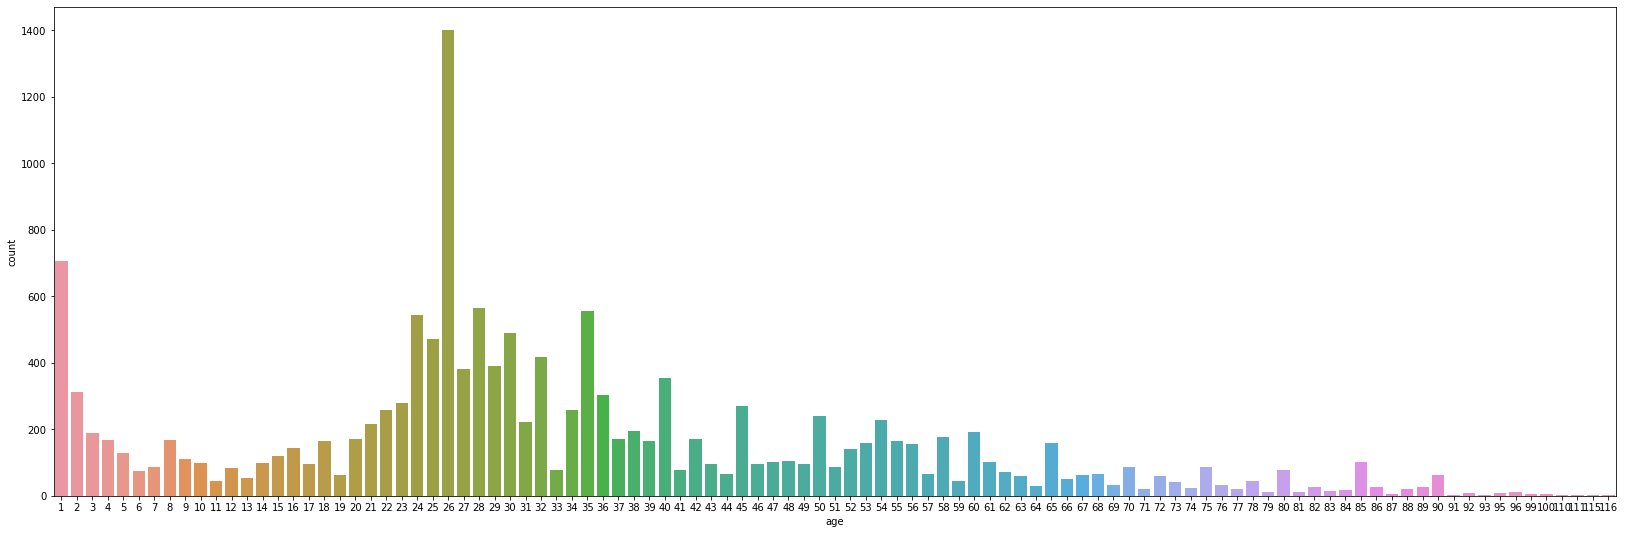

In [187]:
# load the datasets using the csv files train, val and test 
# (3)
train=pd.read_csv('data/train.csv')
test=pd.read_csv('data/test.csv')
val=pd.read_csv('data/val.csv')
# print the shapes of the dataframes 
# (3)
print(train.shape)
print(test.shape)
print(val.shape)
# print the column names from either one of the dataframes 
# (1)
print(train.columns)
# print the proportional distribution of gender in all three datasets(i.e., number of male and female) 
# (3)
print('Proportion of Female in train'+' : '+ str(len(train[train['gender']==0])/len(train.index)))
print('Proportion of Female in test'+' : '+ str(len(test[test['gender']==0])/len(test.index)))
print('Proportion of Female in val'+' : '+ str(len(val[val['gender']==0])/len(val.index)))
print('Proportion of Male in train'+' : '+ str(len(train[train['gender']==1])/len(train.index)))
print('Proportion of Male in test'+' : '+ str(len(test[test['gender']==1])/len(test.index)))
print('Proportion of Male in val'+' : '+ str(len(val[val['gender']==1])/len(val.index)))
# print the proportional distribution of ethnicity in all three datasets 
# (3)
for i,k in zip([train,test,val],['train','test','val']):
    for j in range(0,5):
        print('Proportion of ethinicity'+ ' ' + str(j) + ' in ' + k + ' : ' + str(len(i[i['ethnicity']==j])/len(i.index)))
        
# plot the age distribution from the training dataset where the x-axis plots the age and the y-axis depicts the count of individuals within each age group. For example, individuals with age=1 are:
import seaborn as sns
plt.rcParams['figure.figsize']=(28,9)
sns.countplot(train['age'])
plt.show()
# (2)

#### Create the ImageDataGenerators (22/100)

In [198]:
import cv2
Training_images=[]
Training_lables=[]
Validation_images=[]
Validation_labels=[]
for img in os.listdir('data/images/train'):
    image=cv2.imread('data/images/train/'+img)
    source=train[train['img_name']==img]
    Training_images.append(image)
    Training_lables.append((int(source['age']),int(source['gender']),int(source['ethnicity'])))
for img in os.listdir('data/images/val'):
    image=cv2.imread('data/images/val/'+img)
    source=val[val['img_name']==img]
    Validation_images.append(image)
    Validation_labels.append((int(source['age']),int(source['gender']),int(source['ethnicity'])))
    
Training_images=np.array(Training_images)
Validation_images=np.array(Validation_images)

In [201]:
Training_images.shape,Validation_images.shape

((15026, 48, 48, 3), (3757, 48, 48, 3))

In [209]:
train_age=np.array(Training_lables)[:,0]
train_gender=np.array(Training_lables)[:,1]
train_ethinicity=np.array(Training_lables)[:,2]

val_age=np.array(Validation_labels)[:,0]
val_gender=np.array(Validation_labels)[:,1]
val_ethinicity=np.array(Validation_labels)[:,2]

#### TensorBoard lunch comands

In [314]:
from datetime import datetime
from packaging import version
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [317]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(logdir + "/metrics")
file_writer.set_as_default()
def lr_schedule(epoch):
    learning_rate = 0.2
    if epoch > 5:
        learning_rate = 0.02
    if epoch > 8:
        learning_rate = 0.01
    if epoch > 10:
        learning_rate = 0.005

    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

#### Create the model (44/100)

In [318]:
# Firstly The Input layer of shape 48,48,3

Input=keras.layers.Input(shape=(48,48,3),name='Input')

# Then we add Conv2d Layer of 32 filters and 3 x 3 kernel size with padding same and relu activation

Conv2d_1=keras.layers.Conv2D(32,(7,7),padding='same',activation='relu',name='Conv2d_1')(Input)

# Then we add pooling 2d layer to reduce the size of parameters

pool2d_1=keras.layers.AveragePooling2D((2,2),name='Pool2d_1')(Conv2d_1)

# Then we add Conv2d Layer of 16 filters and 3 x 3 kernel size with padding same and relu activation

Conv2d_2=keras.layers.Conv2D(16,(5,5),padding='same',activation='relu',name='Conv2d_2')(pool2d_1)

# Again we add 2nd pooling2d layer for peremeter reduction

pool2d_2=keras.layers.AveragePooling2D((2,2),name='Pool2d_2')(Conv2d_2)

# Then we add Conv2d Layer of 32 filters and 3 x 3 kernel size with padding same and relu activation

Conv2d_3=keras.layers.Conv2D(3,(3,3),padding='same',activation='relu',name='Conv2d_3')(pool2d_2)

Flat=keras.layers.Flatten(name='Flatten')(Conv2d_3)

Dense_1=keras.layers.Dense(500,activation='selu',name='Dense_1')(Flat)

Dense_=keras.layers.Dense(250,activation='selu',name='Dense_mid')(Flat)

Dense_2=keras.layers.Dense(100,activation='selu',name='Dense_2')(Dense_)

output_1=keras.layers.Dense(1,name='Age')(Dense_2)

output_2=keras.layers.Dense(1,activation='sigmoid',name='Gender')(Dense_2)

output_3=keras.layers.Dense(5,activation='softmax',name='Ethnicity')(Dense_2)

MTL_Model=keras.models.Model([Input],[output_1,output_2,output_3])
MTL_Model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.05),
                 loss={
                     'Age':'mse',
                     'Gender':'binary_crossentropy',
                     'Ethnicity':'sparse_categorical_crossentropy'
                 },
                  metrics={
                       'Age':'mae',
                     'Gender':'Accuracy',
                     'Ethnicity':'Accuracy'
                  }
                 )
MTL_Model.fit(Training_images,[train_age,train_gender,train_ethinicity],epochs=10,
    validation_data=(Validation_images,[val_age,val_gender,val_ethinicity]),callbacks=[tensorboard_callback, lr_callback])

Epoch 1/10
470/470 [==============================] - 35s 73ms/step - loss: 8699860521844736.0000 - Age_loss: 8699860521844736.0000 - Gender_loss: 505846.5625 - Ethnicity_loss: 1168260.7500 - Age_mae: 4199411.5000 - Gender_Accuracy: 0.4989 - Ethnicity_Accuracy: 0.2643 - val_loss: 704.6274 - val_Age_loss: 499.5900 - val_Gender_loss: 15.0686 - val_Ethnicity_loss: 189.9686 - val_Age_mae: 19.0265 - val_Gender_Accuracy: 0.4770 - val_Ethnicity_Accuracy: 0.4240 - lr: 0.2000
Epoch 2/10
470/470 [==============================] - 38s 80ms/step - loss: 682.2915 - Age_loss: 454.8159 - Gender_loss: 45.9888 - Ethnicity_loss: 181.4864 - Age_mae: 16.6425 - Gender_Accuracy: 0.5011 - Ethnicity_Accuracy: 0.2699 - val_loss: 665.6506 - val_Age_loss: 428.7565 - val_Gender_loss: 12.5900 - val_Ethnicity_loss: 224.3042 - val_Age_mae: 17.1390 - val_Gender_Accuracy: 0.4770 - val_Ethnicity_Accuracy: 0.1908 - lr: 0.2000
Epoch 3/10
470/470 [==============================] - 37s 79ms/step - loss: 721.8463 - Age_loss

In [319]:
%tensorboard --logdir logs/scalars

#### Making predictions on test data (14/100)

In [249]:
# evaluate the trained model using the test generator

Test_images=[]
Test_lables=[]
for img in os.listdir('data/images/test'):
    image=cv2.imread('data/images/test/'+img)
    source=test[test['img_name']==img]
    Test_images.append(image)
    Test_lables.append((int(source['age']),int(source['gender']),int(source['ethnicity'])))


# print only the test accuracy for ethnicity and gender predictions    

Test_images=np.array(Test_images)

test_age=np.array(Test_lables)[:,0]
test_gender=np.array(Test_lables)[:,1]
test_ethinicity=np.array(Test_lables)[:,2]

MTL_Model.evaluate(Test_images,[test_age,test_gender,test_ethinicity])

147/147 [==============================] - 3s 19ms/step - loss: 396.0259 - Age_loss: 393.7896 - Gender_loss: 0.6932 - Ethnicity_loss: 1.5429 - Age_mae: 15.1499 - Gender_Accuracy: 0.5230 - Ethnicity_Accuracy: 0.4240


[396.02587890625,
 393.78961181640625,
 0.6932421326637268,
 1.542854905128479,
 15.149919509887695,
 0.5229982733726501,
 0.4239778518676758]

#### Present prediction results on test data(5/100)

In [289]:
Results=pd.DataFrame(columns=['Hyperparameters','Age(MAE)','Ethnicity(Accuracy)','Gender(Accuracy)'])

In [307]:
df2={'Hyperparameters':'Lr: 0.05 epoch: 6 opt: Adam','Age(MAE)':15.3282,'Ethnicity(Accuracy)':0.2867,'Gender(Accuracy)':0.5051} 
Results=Results.append(df2, ignore_index = True)

C:\Users\asad3\AppData\Local\Temp/ipykernel_13016/871739277.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Results=Results.append(df2, ignore_index = True)


Present your findings for 5 different runs by fine-tuning the hyperparameters. The results table must contain the following fields
- A minimum of 5 hyperparameters that you have fine-tuned
- Mean absolute error for age
- Accuracy for ethnicity prediction
- Accuracy for gender prediction
Please use a table format similar to the one mentioned below when presenting the results.

| Hyperparameters | Age(MAE) | Ethnicity(Accuracy)| Gender(Accuracy) |
|-----------------|----------|--------------------|------------------|
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |
|                 |          |                    |                  |


In [308]:
Results

,Hyperparameters,Age(MAE),Ethnicity(Accuracy),Gender(Accuracy)
0,Lr: 0.01 epoch: 10 opt: Adam,394.0305,0.380739,0.4977
1,Lr: 0.001 epoch: 10 opt: Adam,6.9302,0.5584,0.7799
2,Lr: 0.01 epoch: 5 opt: RMSProp,15.3837,0.3316,0.4986
3,Lr: 0.0001 epoch: 6 opt: RMSProp,9.7096,0.4779,0.671
4,Lr: 0.05 epoch: 6 opt: Adam,15.3282,0.2867,0.5051


In [309]:
Results.to_csv('Concluded_Results.csv')

# Download Model and getting Weights

In [311]:
keras.models.save_model(MTL_Model,'models')

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets
